In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
import bct
import nibabel as nib
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import ttest_rel
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import wilcoxon
import seaborn as sns
from statsmodels import robust
from statsmodels.formula.api import ols

In [35]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
rcParams['figure.autolayout'] = True
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches

In [36]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

In [37]:
outfolder = '/imaging/jb07/ZDHHC9/connectome_revisions/figures/'

In [38]:
def plot_adjacency_matrix(network, filename):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    rcParams['xtick.labelsize'] = 6 
    rcParams['ytick.labelsize'] = 6  

    ## Loading labels
    labels = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values

    plt.figure(figsize=(double_column, double_column), dpi=300)
    im = plt.imshow(network, 
               cmap='afmhot',
               interpolation='none',
               vmin=0,
               vmax=1)
    ax = plt.gca()
    ax.set_yticks(np.arange(0,network.shape[0]))
    ax.set_yticklabels(labels)
    ax.yaxis.tick_right()
    ax.set_xticks(np.arange(0,network.shape[0]))
    ax.set_xticklabels(labels, rotation=90)
    ax.grid('off')
    
    rcParams['xtick.labelsize'] = 9
    rcParams['ytick.labelsize'] = 9  
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb = plt.colorbar(im, cax=cax)
    #cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)
    plt.savefig(filename, dpi=600)
    plt.show()

In [39]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    if weight == '_FA':
        weight_switch = str(0)
    elif weight == '_RD':
        weight_switch = str(1)
    elif weight == '_GFA':
        weight_switch = str(2)
        
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix' + weight_switch + '/' + subject + weight + '_matrix.txt'
    matrix = np.loadtxt(matrix)
    
    # Exclude label entries 
    entries_to_exclude = [1, 2, 3, 4, 10, 11, 15, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
    matrix = np.delete(matrix,entries_to_exclude, axis=0)
    matrix = np.delete(matrix,entries_to_exclude, axis=1)
    
    # Removing NaN values
    matrix[np.isnan(matrix)] = 0
    
    return matrix

In [40]:
folder = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/'

In [41]:
subject_list = sorted([subject.split('_')[-1] for subject in os.listdir(folder) if re.search('subject', subject)])

## Comparing nuisance variable

RMS displacement

In [134]:
df = pd.read_csv('/imaging/jb07/ZDHHC9/motion/Displacements_Results.csv')

In [138]:
for group in ['ZDHHC9', 'control']:
    print(group)
    print('mean: ' + str(round(np.mean(df[df['group'] == group]['Unnamed: 1']), 2)))
    print('SE: ' + str(round(sem(df[df['group'] == group]['Unnamed: 1']), 3)))
    print('median: ' + str(round(np.median(df[df['group'] == group]['Unnamed: 1']), 2)))
    print('mad: '+ str(round(robust.mad(df[df['group'] == group]['Unnamed: 1']), 3)))

ZDHHC9
mean: 2.1
SE: 0.292
median: 1.97
mad: 0.648
control
mean: 1.8
SE: 0.304
median: 1.53
mad: 0.314


In [79]:
ttest_rel(df[df['group'] == 'control']['Unnamed: 1'], df[df['group'] == 'ZDHHC9']['Unnamed: 1'])

Ttest_relResult(statistic=-0.58985872368309544, pvalue=0.57680805175906857)

In [80]:
wilcoxon(df[df['group'] == 'control']['Unnamed: 1'], df[df['group'] == 'ZDHHC9']['Unnamed: 1'])

WilcoxonResult(statistic=10.0, pvalue=0.49896229860376107)

Number of corrupted voxels

In [139]:
in_folder = '/imaging/jb07/ZDHHC9/connectome_revisions/connectome/'
d = []

for subject in subject_list:
    filename = in_folder + '_subject_id_' + subject + '/dwi_preproc/eddy/eddy_corrected.eddy_outlier_map'

    sums = list()

    with open(filename) as f:
        next(f)
        for line in f:
            values = np.asarray(line[:-2].split(' '))
            sums.append(np.sum([int(value) for value in values]))

    total = np.sum(sums)
    group = 'control' if re.search('c', subject) else 'ZDHHC9'
    
    d.append({'subject': subject,
              'outliers': total,
              'group': group})
df = pd.DataFrame(d)

In [140]:
for group in ['ZDHHC9', 'control']:
    print(group)
    print('mean: ' + str(round(np.mean(df[df['group'] == group]['outliers']), 2)))
    print('SE: ';  str(round(sem(df[df['group'] == group]['outliers']), 3)))
    print('median: ' + str(round(np.median(df[df['group'] == group]['outliers']), 2)))
    print('mad: '+ str(round(robust.mad(df[df['group'] == group]['outliers']), 3)))

ZDHHC9
mean: 12.71
SE: 2.254
median: 11.0
mad: 5.93
control
mean: 10.0
SE: 3.078
median: 8.0
mad: 5.93


In [131]:
ttest_rel(df[df['group'] == 'control']['outliers'], df[df['group'] == 'ZDHHC9']['outliers'])

Ttest_relResult(statistic=-1.0921223729660698, pvalue=0.31667963027925633)

In [132]:
wilcoxon(df[df['group'] == 'control']['outliers'], df[df['group'] == 'ZDHHC9']['outliers'])

WilcoxonResult(statistic=8.0, pvalue=0.31049443431723489)

## Plotting overview matrices

In [42]:
control_networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(10), '_FA', subject) for subject in subject_list if re.search('c', subject)]), 0, 3)
ZDHHC9_networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(10), '_FA', subject) for subject in subject_list if re.search('z', subject)]), 0, 3)

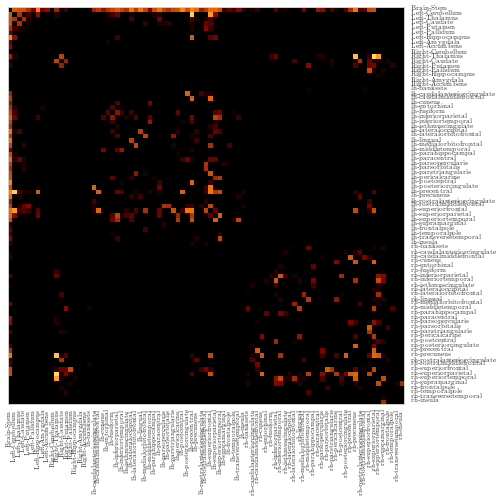

In [565]:
plot_adjacency_matrix(np.mean(ZDHHC9_networks, axis=2), outfolder + 'ZDHHC9_adjmat.png')

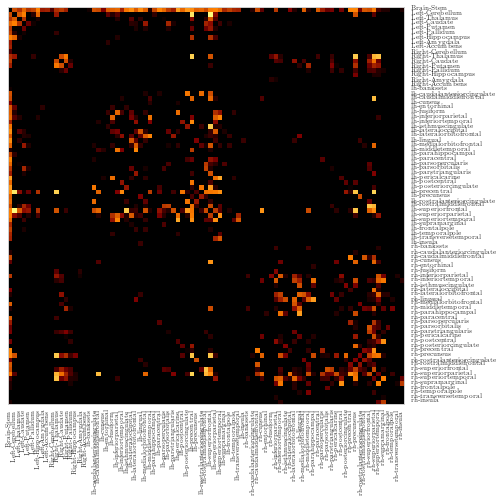

In [566]:
plot_adjacency_matrix(np.mean(control_networks, axis=2), outfolder + 'control_adjmat.png')

Creating files for visualization with BrainNet Viewer

In [22]:
control_network = np.mean(control_networks, axis=2)
control_network = control_network[17:, :]
control_network = control_network[:, 17:]
np.savetxt(outfolder + 'control_mean.txt', control_network)
#np.savetxt(outfolder + 'ZDHHC9_mean.txt', np.mean(ZDHHC9_networks, axis=2))

In [721]:
np.unique(roi_data)[1:2]

array([2], dtype=int32)

In [28]:
def make_BrainNet_file(filename, network, out_file, labels_file):
    import bct
    import nibabel as nib
    import numpy as np
    import pandas as pd

    # Loading the data
    img = nib.load(filename)
    data = img.get_data()
    affine = img.affine
    labels = sorted(pd.read_csv(labels_file)['label_number'].values)

    # Calculating the centroids - the crucial part is to apply the affine to get from voxel to real-world coordinates
    get_centroid = lambda label: nib.affines.apply_affine(affine, np.mean(np.where(data == label), axis=1))
    centroids = np.asarray([get_centroid(label) for label in labels])

    # This creates a .node file to use with BrainNet viewer
    degrees = bct.degrees_und(network)

    df = pd.DataFrame({'x': np.round(centroids[:, 0], 2),
                     'y': np.round(centroids[:, 1], 2),
                     'z': np.round(centroids[:, 2], 2),
                     'colour': degrees,
                     'size': degrees})

    df['label'] = labels
    df[['x','y','z','colour','size', 'label']].to_csv(out_file, header=None, index=False, sep='\t')

In [31]:
filename =  '/home/jb07/Desktop/temp/FreeSurfer/CBU_MNI152/mri/aparc+aseg.nii.gz'
out_file = '/home/jb07/Desktop/temp/nodes.node'
labels_file = '/home/jb07/Desktop/temp/labels.csv'
network = np.mean(ZDHHC9_networks, axis=2)
network = network[1:,:]
network = network[:,1:]
np.savetxt(outfolder + '/ZDHHC9.edge', network)
make_BrainNet_file(filename, network, out_file, labels_file)

In [30]:
filename =  '/home/jb07/Desktop/temp/FreeSurfer/CBU_MNI152/mri/aparc+aseg.nii.gz'
out_file = '/home/jb07/Desktop/temp/nodes.node'
labels_file = '/home/jb07/Desktop/temp/labels.csv'
network = np.mean(control_networks, axis=2)
network = network[1:,:]
network = network[:,1:]
np.savetxt(outfolder + '/control.edge', network)
make_BrainNet_file(filename, network, out_file, labels_file)

## Comparison of edge weight by region

In [43]:
d = []
threshold_range = np.arange(0,100,10)

for subject in subject_list:
    for threshold in threshold_range:
        
        # Loading the adjacency matrix
        network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
        
        # Getting the labels for the matrix
        labels = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values
        
        subcortical_labels = [np.where(labels == label)[0][0] for label in labels if re.search('(Left|Right)', label)]
        lh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('lh', label)]
        rh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('rh', label)]

        mean_connection_strength = list()
        
        # Selecting subcortical, left and right cortical, and cortical interhemispheric connections
        for labels in [(subcortical_labels, subcortical_labels), (lh_labels, lh_labels), (rh_labels, rh_labels), (lh_labels, rh_labels)]:
            subconnections = network.copy()
            subconnections = subconnections[labels[0], ...]
            subconnections = subconnections[..., labels[1]]
            mean_connection_strength.append(np.mean(subconnections))
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'
        
        d.append({'ID': subject,
                  'group': group,
                 'threshold': threshold,
                 'subcortical': mean_connection_strength[0],
                 'lh': mean_connection_strength[1],
                 'rh': mean_connection_strength[2],
                 'interhemispheric':mean_connection_strength[3]})
        
df = pd.DataFrame(d)

/imaging/local/software/anaconda/2.4.1/2/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


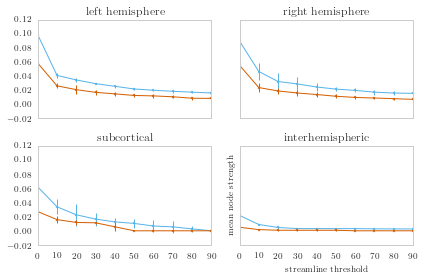

In [44]:
fig = plt.figure(figsize=(single_column, single_column), dpi=600)
fig,axs = plt.subplots(2,2, sharex=True, sharey=True)
ordering = [[1,0],[0,0], [0,1], [1,1]]
titles = ['subcortical', 'left hemisphere', 'right hemisphere', 'interhemispheric']
counter = 0

for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'
        
        axs[ordering[counter][0], ordering[counter][1]].errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle='solid',
                     linewidth=1)
        axs[ordering[counter][0], ordering[counter][1]].set_title(titles[counter])
    counter += 1

    if measure == 'subcortical':
        plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
        plt.xlabel('streamline threshold')
        plt.ylabel('mean node strength')
        
plt.savefig(outfolder + '/regional_node_strength.png', dpi=600)
plt.show()

In [45]:
for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

subcortical

ZDHHC9 AUC: mean=0.08; SE=0.011
ZDHHC9 AUC: median=0.07; mad=0.033
control AUC: mean=0.18; SE=0.018
control AUC: median=0.18; mad=0.062
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.32; p=0.002 corrected-p=0.007

lh

ZDHHC9 AUC: mean=0.19; SE=0.012
ZDHHC9 AUC: median=0.18; mad=0.034
control AUC: mean=0.33; SE=0.012
control AUC: median=0.31; mad=0.014
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=11.68; p=0.0 corrected-p=0.0

rh

ZDHHC9 AUC: mean=0.16; SE=0.01
ZDHHC9 AUC: median=0.18; mad=0.015
control AUC: mean=0.3; SE=0.022
control AUC: median=0.31; mad=0.094
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=7.02; p=0.0 corrected-p=0.002

interhemispheric

ZDHHC9 AUC: mean=0.01; SE=0.004
ZDHHC9 AUC: median=0.01; mad=0.008
control AUC: mean=0.06; SE=0.005
control AUC: median=0.06; mad=0.012
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=8.76; p=0.0 corrected-p=0.0



/home/jb07/python_modules/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Creating a $Latex$ version of the table

In [53]:
d = []
for measure in ['subcortical', 'lh', 'rh', 'interhemispheric']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_W': round(shapiro(ZDHHC9_area)[0], 2), 
    'ZDHHC9_p': round(shapiro(ZDHHC9_area)[1], 2),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_W': round(shapiro(control_area)[0], 2), 
    'control_p': round(shapiro(control_area)[1], 2), 
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_W', 'ZDHHC9_p', 'control_mean', 'control_SE', 'control_W', 'control_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
          measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_W &  ZDHHC9\_p &  control\_mean &  control\_SE &  control\_W &  control\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
      subcortical &         0.08 &      0.011 &      0.97 &      0.92 &          0.18 &       0.018 &       0.93 &       0.54 &        5.32 &    0.002 &        0.007 \\
               lh &         0.19 &      0.012 &      0.98 &      0.95 &          0.33 &       0.012 &       0.82 &       0.07 &       11.68 &    0.000 &        0.000 \\
               rh &         0.16 &      0.010 &      0.82 &      0.06 &          0.30 &       0.022 &       0.90 &       0.36 &        7.02 &    0.000 &        0.002 \\
 interhemispheric &         0.01 &      0.004 &      0.84 &      0.11 &          0.06 &       0.005 &       0.91 &       0.38 &        8.76 &    0.000 &        0.000 \\
\bottomrule
\end{tabular}



## Graph theory analysis

Correlation of graph metrics

In [171]:
d = []

for subject in subject_list:
    network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
    network[np.isnan(network)] = 0 # removing NaN

    # Calculating graph metrics
    d.append({'subject': subject,
             'degree': np.mean(bct.degrees_und(network)),
             'strength': np.mean(bct.strengths_und(network)),
             'clustering_coefficient': np.mean(bct.clustering_coef_wu(network)),
             'global_efficiency': np.mean(bct.charpath(bct.distance_wei(bct.weight_conversion(network, 'lengths'))[0])[1])})

In [181]:
print(pd.DataFrame(d)[['degree', 'strength', 'clustering_coefficient', 'global_efficiency']].corr().round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  degree &  strength &  clustering\_coefficient &  global\_efficiency \\
\midrule
degree                 &    1.00 &      0.99 &                    0.86 &               0.96 \\
strength               &    0.99 &      1.00 &                    0.89 &               0.98 \\
clustering\_coefficient &    0.86 &      0.89 &                    1.00 &               0.94 \\
global\_efficiency      &    0.96 &      0.98 &                    0.94 &               1.00 \\
\bottomrule
\end{tabular}



### 1. Mean node degree & strength

Because the node degree has a large influence on all other graph measures, differences in mean node degree are investigated first. The following section calculates the average node degree in the network for participants in the *ZDHHC9* and control group over a range of streamline thresholds. The groups are compared on the area under the curve of mean node degree across thresholds. 

In [54]:
threshold_range = np.arange(0,100,10)
d = []

for threshold in threshold_range:
    for subject in subject_list:
        network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
        network[np.isnan(network)] = 0 # removing NaN
        
        # Calculating graph metrics
        mean_degree = np.mean(bct.degrees_und(network))
        mean_strength = np.mean(bct.strengths_und(network))
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'

        # Collecting the data
        d.append({'ID':subject, 
                  'threshold': threshold,
                  'group': group,
                  'mean_degree': mean_degree,
                  'mean_strength': mean_strength})
        
df = pd.DataFrame(d)

In [55]:
for measure in ['mean_degree', 'mean_strength']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

mean_degree

ZDHHC9 AUC: mean=22.23; SE=0.921
ZDHHC9 AUC: median=21.98; mad=2.163
control AUC: mean=33.18; SE=1.056
control AUC: median=32.94; mad=3.384
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=10.14; p=0.0 corrected-p=0.0

mean_strength

ZDHHC9 AUC: mean=9.57; SE=0.487
ZDHHC9 AUC: median=9.86; mad=1.648
control AUC: mean=16.34; SE=0.645
control AUC: median=15.64; mad=1.785
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=13.08; p=0.0 corrected-p=0.0



In [56]:
d = []
for measure in ['mean_degree', 'mean_strength']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_W': round(shapiro(ZDHHC9_area)[0], 2), 
    'ZDHHC9_p': round(shapiro(ZDHHC9_area)[1], 2),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_W': round(shapiro(control_area)[0], 2), 
    'control_p': round(shapiro(control_area)[1], 2), 
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_W', 'ZDHHC9_p', 'control_mean', 'control_SE', 'control_W', 'control_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
       measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_W &  ZDHHC9\_p &  control\_mean &  control\_SE &  control\_W &  control\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
   mean\_degree &        22.23 &      0.921 &      0.96 &      0.85 &         33.18 &       1.056 &        0.9 &       0.34 &       10.14 &        0 &            0 \\
 mean\_strength &         9.57 &      0.487 &      0.97 &      0.86 &         16.34 &       0.645 &        0.9 &       0.31 &       13.08 &        0 &            0 \\
\bottomrule
\end{tabular}



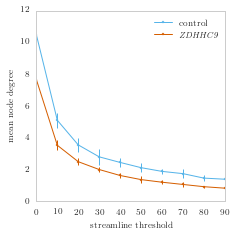

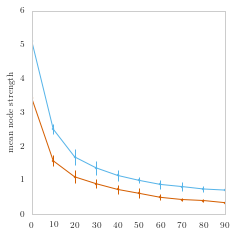

In [59]:
labels = ['mean node degree', 'mean node strength']
counter = 0

for measure in ['mean_degree','mean_strength']:
    fig = plt.figure(figsize=(single_column, single_column), dpi=600)

    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'

        plt.errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle='solid',
                     linewidth=1)

    if counter == 0:
        plt.legend(['control', r'\textit{ZDHHC9}'], loc='best')
        plt.xlabel('streamline threshold')
    plt.ylabel(labels[counter])
    plt.savefig(outfolder + '/' + labels[counter] + '.png', dpi=600)
    plt.show()
    counter += 1

### 3. Clustering coefficient & Global efficiency
The mean node degree analysis indicated significant differences between the groups. Differences in $D_{G}$ may influence other graph measures. Consensus thresholding is applied to equalize the number of connections in both groups

In [62]:
def consensus_thresholding(in_matrices, percentage_threshold):
    # ===============================================================#
    # Consensus thresholding of connectivity matrices 
    # for method see: http://www.ncbi.nlm.nih.gov/pubmed/23296185
    # ===============================================================#
    """
    inputs:
    in_matrices: numpy array with connectivity matrices (dimensions: ROIs x ROIs x participants)
    percentage_threshold: ratio of connections to be retained, e.g. 0.6

    outputs:
    matrices only retained connections that occured in the percentage threshold of participants
    """

    import bct
    import numpy as np
    
    connection_consensus = np.sum(np.asarray(in_matrices > 0), 2).astype('float64')/in_matrices.shape[2]
    connection_consensus = bct.binarize(bct.threshold_absolute(W=connection_consensus, thr=percentage_threshold))
    consensus_matrices = in_matrices * np.reshape(np.repeat(connection_consensus,in_matrices.shape[2]), newshape=in_matrices.shape)
    
    return consensus_matrices

In [63]:
d = []

for threshold in np.arange(0,100,10):
    
    # Consensus thresholding to equalise the graph density between groups
    networks = np.rollaxis(np.asarray([load_data(folder, 'CSD', str(threshold), '_FA', subject) for subject in subject_list]), 0, 3)
    networks_before = networks.copy()
    networks = consensus_thresholding(networks, 1)
    
    # Calculating graph measures in the matched networks
    for i in range(0,len(subject_list)):
        subject = subject_list[i]

        # Calculating graph metrics
        mean_degree = np.mean(bct.degrees_und(networks[...,i]))
        clustering_coefficient = np.mean(bct.clustering_coef_wu(networks[...,i]))
        global_efficiency = bct.charpath(bct.distance_wei(bct.weight_conversion(networks[...,i], 'lengths'))[0])[1]
        clustering_coefficient_before = np.mean(bct.clustering_coef_wu(networks_before[...,i]))
        global_efficiency_before = bct.charpath(bct.distance_wei(bct.weight_conversion(networks_before[...,i], 'lengths'))[0])[1]
        
        # Setting group variable
        group = 'ZDHHC9' if re.search('z', subject) else 'control'

        # Collecting the data
        d.append({'ID':subject, 
                  'group': group,
                  'threshold': threshold,
                  'mean_degree': mean_degree,
                  'clustering_coefficient_before': clustering_coefficient_before,
                  'clustering_coefficient': clustering_coefficient,
                  'global_efficiency_before': global_efficiency_before,
                  'global_efficiency': global_efficiency})

df = pd.DataFrame(d)

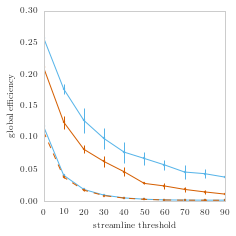

In [64]:
labels = ['global clustering coefficient', 'global efficiency']
counter = 0

fig = plt.figure(figsize=(single_column, single_column), dpi=600)

#for measure in ['clustering_coefficient', 'clustering_coefficient_before']:
for measure in ['global_efficiency', 'global_efficiency_before']:

    for group in ['control', 'ZDHHC9']:

        copy_df = df.copy()
        copy_df = copy_df[df['group'] == group]
        median = copy_df.groupby('threshold').median()[measure].values
        mad = copy_df.groupby('threshold').agg(robust.mad)[measure].values
        colour = '#56B4E9' if group == 'control' else '#D55E00'
        marker = 'o' if measure == 'clustering_coefficient' else 'D'
        linetype = 'dashed' if counter == 1 else 'solid'
        
        plt.errorbar(x = threshold_range,
                     y = median,
                     yerr = mad,
                     marker = marker,
                     markersize = 2,
                     color=colour,
                     linestyle=linetype,
                     linewidth=1)
        counter += 1
        
plt.xlabel('streamline threshold')
plt.ylabel(labels[1])
plt.savefig(outfolder + labels[1] + '.png', dpi=600)
plt.show()

In [65]:
for measure in ['clustering_coefficient', 'global_efficiency']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]
    print measure + '\n'
    print('ZDHHC9 AUC: mean=' + str(round(np.mean(ZDHHC9_area), 2)) +
         '; SE=' + str(round(sem(ZDHHC9_area), 3)))
    print('ZDHHC9 AUC: median=' + str(round(np.median(ZDHHC9_area), 2)) +
         '; mad=' + str(round(robust.mad(ZDHHC9_area), 3)))
    print('control AUC: mean=' + str(round(np.mean(control_area), 2)) +
         '; SE=' + str(round(sem(control_area), 3)))
    print('control AUC: median=' + str(round(np.median(control_area), 2)) +
         '; mad=' + str(round(robust.mad(control_area), 3)))
    print('Wilcoxon: W=' + 
    str(wilcoxon(control_area, ZDHHC9_area)[0]) + '; p=' +
    str(round(wilcoxon(control_area, ZDHHC9_area)[1], 3)))
    print('Paired t-test: t(' + str(len(control_area) -1) + ')=' + 
    str(round(ttest_rel(control_area, ZDHHC9_area)[0], 2)) + '; p=' +
    str(round(ttest_rel(control_area, ZDHHC9_area)[1], 3)) + ' corrected-p=' + 
    str(round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)) + '\n')

clustering_coefficient

ZDHHC9 AUC: mean=0.2; SE=0.003
ZDHHC9 AUC: median=0.2; mad=0.007
control AUC: mean=0.21; SE=0.003
control AUC: median=0.21; mad=0.006
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.91; p=0.001 corrected-p=0.004

global_efficiency

ZDHHC9 AUC: mean=0.18; SE=0.003
ZDHHC9 AUC: median=0.18; mad=0.005
control AUC: mean=0.2; SE=0.002
control AUC: median=0.2; mad=0.009
Wilcoxon: W=0.0; p=0.018
Paired t-test: t(6)=5.81; p=0.001 corrected-p=0.005



In [66]:
d = []
for measure in ['clustering_coefficient', 'global_efficiency']:
    control_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('c', subject)]
    ZDHHC9_area = [np.cumsum(df[df['ID'] == subject][measure].values)[-1] for subject in subject_list if re.search('z', subject)]

    d.append({
    'measure': measure,
    'ZDHHC9_mean': round(np.mean(ZDHHC9_area), 2),
    'ZDHHC9_SE': round(sem(ZDHHC9_area), 3),
    'ZDHHC9_W': round(shapiro(ZDHHC9_area)[0], 2), 
    'ZDHHC9_p': round(shapiro(ZDHHC9_area)[1], 2),
    'control_mean': round(np.mean(control_area), 2),
    'control_SE': round(sem(control_area), 3),
    'control_W': round(shapiro(control_area)[0], 2), 
    'control_p': round(shapiro(control_area)[1], 2), 
    'ttest stat': round(ttest_rel(control_area, ZDHHC9_area)[0], 2),
    'ttest p': round(ttest_rel(control_area, ZDHHC9_area)[1], 3),
    'ttest corrp': round(4*ttest_rel(control_area, ZDHHC9_area)[1], 3)
    })
    
result_df = pd.DataFrame(d)
print(result_df[['measure', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_W', 'ZDHHC9_p', 'control_mean', 'control_SE', 'control_W', 'control_p', 'ttest stat', 'ttest p', 'ttest corrp']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
                measure &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_W &  ZDHHC9\_p &  control\_mean &  control\_SE &  control\_W &  control\_p &  ttest stat &  ttest p &  ttest corrp \\
\midrule
 clustering\_coefficient &         0.20 &      0.003 &      0.90 &      0.34 &          0.21 &       0.003 &       0.95 &       0.75 &        5.91 &    0.001 &        0.004 \\
      global\_efficiency &         0.18 &      0.003 &      0.85 &      0.12 &          0.20 &       0.002 &       0.90 &       0.32 &        5.81 &    0.001 &        0.005 \\
\bottomrule
\end{tabular}



## Comparison of topographic variation in graph metrics

In [141]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [142]:
for metric in ['node_degree', 'node_strength', 'clustering_coefficient', 'local_efficiency']:
    AUC = list()

    for subject in subject_list:
        graph_metrics = list()

        # Calculating the graph metric across a range of thresholds
        for threshold in np.arange(0,100,10):
            network = load_data(folder, 'CSD', str(threshold), '_FA', subject)
            if metric == 'node_degree':
                graph_metrics.append(bct.degrees_und(network))
            elif metric == 'node_strength':
                graph_metrics.append(bct.strengths_und(network))
            elif metric == 'clustering_coefficient':
                graph_metrics.append(bct.clustering_coef_wu(network))
            elif metric == 'local_efficiency':
                # This requires to identify the fully connected subcomponent - otherwise some distances are infinite
                newdata = network[bct.get_components(network, no_depend=True)[0] == 1, :] 
                newdata = newdata[:, bct.get_components(network, no_depend=True)[0] == 1] 
                eccentricity = np.zeros(len(network))
                eccentricity[bct.get_components(network, no_depend=True)[0] == 1] = bct.charpath(bct.distance_wei(bct.weight_conversion(newdata, 'lengths'))[0])[2]
                graph_metrics.append(eccentricity)
            
        # calculating the area under the curve across thresholds
        AUC.append(np.cumsum(np.asarray(graph_metrics), axis=0)[-1,:])

    AUC = np.asarray(AUC)
    
    pvals = list()
    tvals = list()
    ZDHHC9_mean = list()
    ZDHHC9_SE = list()
    ZDHHC9_W = list()
    ZDHHC9_p = list()
    control_mean = list()
    control_SE = list()
    control_W= list()
    control_p = list()
    
    for area in np.arange(0,AUC.shape[1]):
        tvals.append(ttest_rel(AUC[0:7, area], AUC[7:14, area])[0])
        pvals.append(ttest_rel(AUC[0:7, area], AUC[7:14, area])[1])
        
        ZDHHC9_mean.append(np.mean(AUC[7:14, area]))
        ZDHHC9_SE.append(sem(AUC[7:14, area]))
        ZDHHC9_W.append(shapiro(AUC[7:14, area])[0])
        ZDHHC9_p.append(shapiro(AUC[7:14, area])[1])
        
        control_mean.append(np.mean(AUC[0:7, area]))
        control_SE.append(sem(AUC[0:7, area]))
        control_W.append(shapiro(AUC[0:7, area])[0])
        control_p.append(shapiro(AUC[0:7, area])[1])

    if np.isnan(pvals).any():
        pvals[np.where(np.isnan(pvals) == True)[0]] = 1
    corrected_pvals = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
    
    np.savetxt(outfolder + '/regional_comparison/' +  metric + '_p.txt', pvals)
    np.savetxt(outfolder + '/regional_comparison/' +  metric + '_t.txt', tvals)
    np.savetxt(outfolder + '/regional_comparison/' +  metric + '_pcorrected.txt', corrected_pvals)
    
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_mean.txt', ZDHHC9_mean)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_SE.txt', ZDHHC9_SE)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_W.txt', ZDHHC9_W)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_p.txt', ZDHHC9_p)
    
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_control_mean.txt', control_mean)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_control_SE.txt', control_SE)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_control_W.txt', control_W)
    np.savetxt(outfolder + '/regional_comparison/' + metric + '_control_p.txt', control_p)

/home/jb07/python_modules/ipykernel/__main__.py:55: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


KeyboardInterrupt: 

In [162]:
labels = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values

for metric in ['node_degree', 'node_strength', 'clustering_coefficient', 'local_efficiency']:
    
    # Loading all values
    ZDHHC9_mean = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_mean.txt')
    ZDHHC9_SE = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_SE.txt')
    ZDHHC9_W = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_W.txt')
    ZDHHC9_p = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_p.txt')

    control_mean = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_mean.txt')
    control_SE = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_SE.txt')
    control_W = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_W.txt')
    control_p = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_p.txt')
    
    pvals = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_p.txt')
    tvals = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_t.txt')
    corrected_pvals = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_pcorrected.txt')
    
    significant_regions = np.where(corrected_pvals < 0.05)[0]
    normal_regions = np.where((ZDHHC9_p > 0.05) & (control_p > 0.05))[0]
    d = []
    
    # Collect the results for regions that survive correction for multiple comparisons
    for significant_region in significant_regions:
        if significant_region in normal_regions:
            d.append({'label': labels[significant_region],
                      'ZDHHC9_mean': round(ZDHHC9_mean[significant_region], 2),
                      'ZDHHC9_SE': round(ZDHHC9_SE[significant_region], 3),
                      'ZDHHC9_W': round(ZDHHC9_W[significant_region], 2),
                      'ZDHHC9_p': round(ZDHHC9_p[significant_region], 3),
                      'control_mean': round(control_mean[significant_region], 2),
                      'control_SE': round(control_SE[significant_region], 3),
                      'control_W': round(control_W[significant_region], 2),
                      'control_p': round(control_p[significant_region], 3),
                      't-value': round(tvals[significant_region], 2),
                      'p-value': round(pvals[significant_region], 3),
                      'corrected_p': round(corrected_pvals[significant_region], 3)
                      })
    
    # Produce a latex table with the results
    print(pd.DataFrame(d)[['label', 'ZDHHC9_mean', 'ZDHHC9_SE', 'ZDHHC9_W', 'ZDHHC9_p', 'control_mean', 'control_SE', 'control_W', 'control_p', 't-value', 'p-value', 'corrected_p']].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
                  label &  ZDHHC9\_mean &  ZDHHC9\_SE &  ZDHHC9\_W &  ZDHHC9\_p &  control\_mean &  control\_SE &  control\_W &  control\_p &  t-value &  p-value &  corrected\_p \\
\midrule
           Left-Caudate &        26.71 &      3.220 &      0.87 &     0.193 &         44.57 &       2.861 &       0.88 &      0.241 &     4.14 &    0.006 &        0.031 \\
          Right-Caudate &        19.29 &      2.661 &      0.83 &     0.088 &         33.86 &       2.586 &       0.92 &      0.472 &     4.85 &    0.003 &        0.020 \\
          Right-Putamen &        17.71 &      4.927 &      0.91 &     0.392 &         36.86 &       5.938 &       0.92 &      0.493 &     4.34 &    0.005 &        0.028 \\
    lh-inferiortemporal &        14.29 &      2.466 &      0.90 &     0.336 &         28.57 &       1.850 &       0.86 &      0.156 &     4.33 &    0.005 &        0.028 \\
 lh-medialorbitofrontal &        23.43 &      1.412 &      0.96 &     0.800 &      

## Correlation between gene expression and regional graph metrics

In [143]:
expression_folder = '/home/jb07/joe_python/GitHub/ZDHHC9_connectome/expression_data/'
metrics = ['node_degree', 'node_strength', 'local_efficiency', 'clustering_coefficient']
genes = ['FMR1', 'GAPDH', 'GRIN2A', 'FOXP2', 'ZDHHC9']

control_pvals = list()
ZDHHC9_pvals = list()

for metric in metrics:
    df = pd.DataFrame()
    df['ZDHHC9Mean'] = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_mean.txt')
    df['controlMean'] = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_mean.txt')
    df.index = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values

    for gene in genes:
        gene_df = pd.read_csv(expression_folder + gene + '_expression_lh.csv').append(pd.read_csv(expression_folder + gene + '_expression_rh.csv'))
        gene_df.index = ['-'.join(label.split('-')[1:]) for label in gene_df.index]
        gene_df = gene_df[['normalizedExpression']]
        gene_df.columns = [gene]
        df = df.merge(gene_df, left_index=True, right_index=True)
        control_pvals.append(ols('controlMean ~ ' + gene, data=df).fit().pvalues[gene])
        ZDHHC9_pvals.append(ols('ZDHHC9Mean ~ ' + gene, data=df).fit().pvalues[gene])

results_df = pd.DataFrame()
results_df['graph_metric'] = np.hstack([np.repeat(metric, 5) for metric in metrics]).tolist()
results_df['gene'] = np.hstack(np.tile(genes, 4)).tolist()
results_df['control'] = multipletests(np.asarray(control_pvals), alpha=0.05, method='bonferroni')[1]
results_df['ZDHHC9'] = multipletests(np.asarray(ZDHHC9_pvals), alpha=0.05, method='bonferroni')[1]
print results_df

              graph_metric    gene   control    ZDHHC9
0              node_degree    FMR1  1.000000  1.000000
1              node_degree   GAPDH  1.000000  1.000000
2              node_degree  GRIN2A  1.000000  1.000000
3              node_degree   FOXP2  1.000000  1.000000
4              node_degree  ZDHHC9  1.000000  1.000000
5            node_strength    FMR1  1.000000  1.000000
6            node_strength   GAPDH  1.000000  1.000000
7            node_strength  GRIN2A  1.000000  1.000000
8            node_strength   FOXP2  1.000000  1.000000
9            node_strength  ZDHHC9  1.000000  1.000000
10        local_efficiency    FMR1  1.000000  1.000000
11        local_efficiency   GAPDH  1.000000  1.000000
12        local_efficiency  GRIN2A  1.000000  1.000000
13        local_efficiency   FOXP2  1.000000  1.000000
14        local_efficiency  ZDHHC9  1.000000  0.439246
15  clustering_coefficient    FMR1  1.000000  0.620279
16  clustering_coefficient   GAPDH  1.000000  1.000000
17  cluste

Note that these values have to be multiplied by two to account for the two group

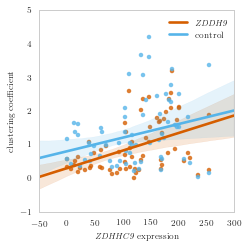

In [442]:
fig = plt.figure(figsize=(double_column/2, double_column/2), dpi=600, tight_layout=True)

sns.regplot(x='ZDHHC9',
            y='ZDHHC9Mean',
            color='#D55E00',
            robust=True,
            data=df)

sns.regplot(x='ZDHHC9',
            y='controlMean',
            color='#56B4E9',
            robust=True,
            data=df)

plt.legend([r'\textit{ZDDH9}', 'control'])
plt.ylabel('clustering coefficient')
plt.xlabel(r'\textit{ZDHHC9} expression')

plt.savefig(outfolder + 'clustcoef_ZDHHC9expr.png', dpi=600)

### Analysis of influential data points

In [489]:
expression_folder = '/home/jb07/joe_python/GitHub/ZDHHC9_connectome/expression_data/'
metric = 'clustering_coefficient'
gene = 'ZDHHC9'

df = pd.DataFrame()
df['ZDHHC9Mean'] = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_ZDHHC9_mean.txt')
df['controlMean'] = np.loadtxt(outfolder + '/regional_comparison/' + metric + '_control_mean.txt')
df.index = pd.read_csv('/home/jb07/joe_python/GitHub/ZDHHC9_connectome/DK_labels.txt', header=None)[0].values

gene_df = pd.read_csv(expression_folder + gene + '_expression_lh.csv').append(pd.read_csv(expression_folder + gene + '_expression_rh.csv'))
gene_df.index = ['-'.join(label.split('-')[1:]) for label in gene_df.index]
gene_df = gene_df[['normalizedExpression']]
gene_df.columns = [gene]
df = df.merge(gene_df, left_index=True, right_index=True)
control_results = ols('controlMean ~ ' + gene, data=df).fit()
ZDHHC9_results = ols('ZDHHC9Mean ~ ' + gene, data=df).fit()

<Container object of 3 artists>

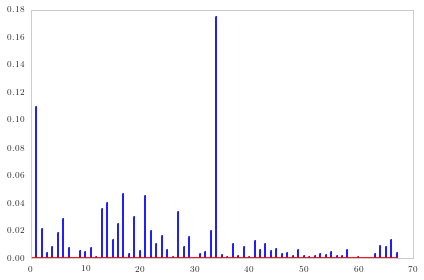

In [490]:
(c, p) = ZDHHC9_results.get_influence().cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")

Influential data point:

In [491]:
print(df.index[np.where(c > 4./(68-2))[0]])
print(c[np.where(c > 4./(68-2))[0]])

Index([u'lh-bankssts', u'lh-caudalanteriorcingulate', u'rh-bankssts'], dtype='object')
[ 0.13630182  0.10965772  0.17549007]


In [495]:
df = df.drop(df.index[np.where(c > 4./(68-2))[0]])
ols('ZDHHC9Mean ~ ' + gene, data=df).fit().pvalues['ZDHHC9']*40

0.001254678194023045